# Model Training notebook

Used to test our model on real data present in folder read-data.  
First run the first cells to load all parameters and pretrained models, then you can predict on the real images.     
The images are in format .tif, which contain 16 images per file, our model can give 1 prediction per image

In [1]:
# Hyperparameters for simulation
nparticles = 1000   # Number of particles
nframes = 16    # Number of steps in the simulation
nposframe = 10    # Number of position per frame
dt = 0.01        # Integration time frame in second (time between two frames)
DGen = 20000        # Diffusion coefficient in nm^2 per s (=0.000001 (um^2)/s)
num_steps = nframes*nposframe
# Hyperparameters for image generation
npixel = 64 # number of image pixels
pixelsize = 100 # in nm 
fwhm_psf = 200 # full width half maximum (emulates microscope)
factor_hr = 5 # image high resulution factor
flux = 100 # number of photons per s
poisson_noise = 100 
gaussian_noise = 10
background = 100 # base background value
normalizeValue = 1000 # value by which all samples will be normalized ! Needs to be fixed and the same for all images !
n_val_im = 50

In [3]:
%reload_ext autoreload
%autoreload 2
from helpers import *
from Models.modelsUtils import *
from Models.simpleCNNModel import *
from Models.ResNetModel2D import *
from Models.ResNetModel3D import *
from Models.paperCNN import *
from Models.paperCNNNoPooling import *
import os.path
import os
import matplotlib.pyplot as plt

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [4]:
# Models used in a dictionnary comprehension. 
# To add  anew model, simply add it to the list with the wanted train fct

lr = 0.000001
models_params = {
    #"simpleCNN": {"class": SimpleCNN, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "resNet2D": {"class": ResNet2D, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "resNet3D": {"class": ResNet3D, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "paperCNNAdam": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "paperCNNSGD": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "sgd", "lr" :lr},
    "paperCNNNoPool": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" :lr}
    
}

In [6]:
for name, params in models_params.items():
    class_ = params["class"]
    # Load the model weights
    loaded_model = class_().to(device)
    filename = "modelsData/w_" + name + ".pth"
    if os.path.exists(filename):
        loaded_model = load_model_weights(loaded_model, filename)
        print(name, "Loaded existing weights")
    else:
        print(name, "Did not find weights, loaded a new model")
        
    params["loaded_model"] = loaded_model  # Update the dictionary with the loaded model
    
    if(isinstance(params["optimizer"],str)):
        if params["optimizer"] == "adam":
            params["optimizer"] = optim.Adam(loaded_model.parameters(), lr=params["lr"])
        elif params["optimizer"] == "sgd":
            params["optimizer"] = optim.SGD(loaded_model.parameters(), lr=params["lr"], momentum=0.9)
        else: 
            params["optimizer"] = optim.Adam(loaded_model.parameters(), lr=params["lr"])

Model weights loaded from modelsData/w_resNet2D.pth
resNet2D Loaded existing weights
Model weights loaded from modelsData/w_resNet3D.pth
resNet3D Loaded existing weights
Model weights loaded from modelsData/w_paperCNNAdam.pth
paperCNNAdam Loaded existing weights
Model weights loaded from modelsData/w_paperCNNSGD.pth
paperCNNSGD Loaded existing weights
Model weights loaded from modelsData/w_paperCNNNoPool.pth
paperCNNNoPool Loaded existing weights


In [ ]:
# Path to the folder containing the images
folder_path = "real-data/blocks_64x64x16_70_01"

# Get a list of all files in the folder
file_list = sorted(os.listdir(folder_path))  # Sorted lexicographically

# Filter only files with valid image extensions and specific naming pattern
valid_extensions = (".tif")
image_files = [f for f in file_list if f.endswith(valid_extensions) and f.startswith("block-001")]

# Initialize an empty list for predictions
predictions = []

params = models_params["resNet2D"]

# Process each .tif file
for file in image_files:
    image_path = os.path.join(folder_path, file)
    
    # Open the .tif file and load all 16 frames
    with Image.open(image_path) as img:
        frames = []
        for i in range(16):  # Assuming each .tif file has exactly 16 frames
            img.seek(i)  # Access frame i
            frame_array = np.array(img) / 18000  # Normalize by 18000
            frames.append(frame_array)
    
    # Convert frames to a NumPy array of shape (16, 64, 64)
    val_images = np.stack(frames, axis=0)
    
    # Query the model for predictions
    model = params["loaded_model"]
    model_preds = predict_diffusion_coefficients(model, val_images, device)
    predictions.append(model_preds)

# Convert predictions to a NumPy array for further processing or saving
predictions = np.array(predictions)

# Print shape of predictions for verification
print("Predictions shape:", predictions.shape)
print(predictions)
# Save predictions if needed
# np.save("predictions.npy", predictions)

Predictions shape: (53,)
[20.95572   23.606     17.89331   19.587463  20.19464   18.667616
  4.5205464 19.75978   18.45448   22.132307  19.6783    21.38229
 19.634356  23.274595  20.902805  20.307198  17.269306  22.85172
 27.380104  19.129597  19.460533  22.571676  20.502659  23.69899
  8.87781   17.752356  23.978498  19.614529  19.446678   1.9124625
 23.471123  28.080599  17.785204  16.809673   8.254526  22.39248
 20.224651  21.544815  21.33533   17.993876  19.492014  22.160864
 19.465527  19.015268  20.01722   25.110502   9.037392  19.405306
 19.90796   14.741604  23.949184  17.618677  15.75448  ]


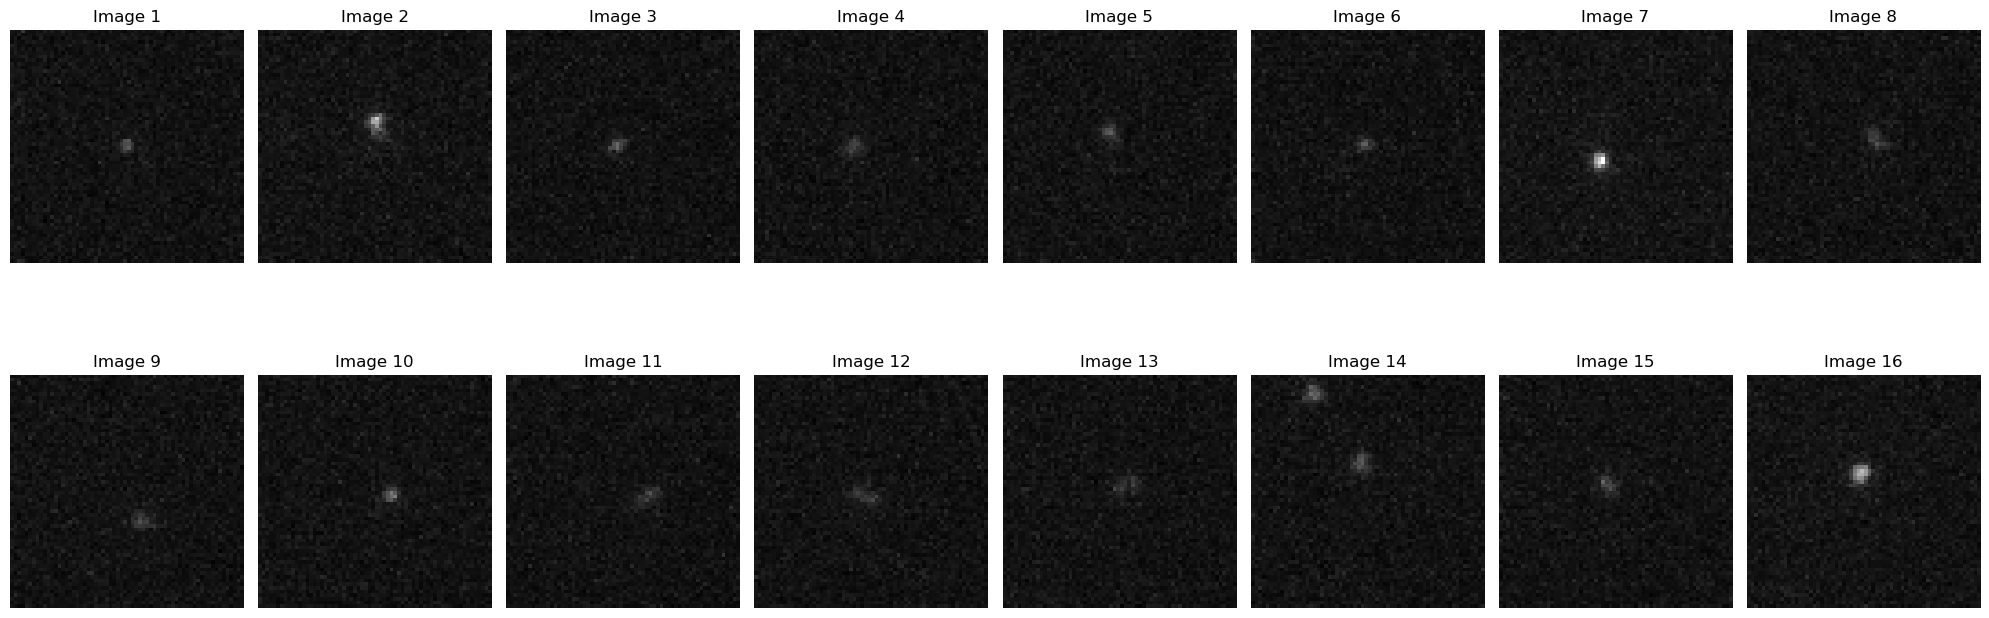

Global Min Intensity: 500, Global Max Intensity: 12410


In [9]:
# Plots the first image with some statistics 

# Path to the folder containing the images
folder_path = "real-data/blocks_64x64x16_70_01"

# Get a list of all files in the folder
file_list = sorted(os.listdir(folder_path))  # Sorted lexicographically

# Filter only files with valid image extensions (e.g., .tif, .jpg, .png)
valid_extensions = (".tif")
image_files = [f for f in file_list if f.endswith(valid_extensions) and f.startswith("block-001")]

# Read all images and determine global min and max intensity
images = []
global_min = float("inf")
global_max = float("-inf")

for file in image_files:

    image_path = os.path.join(folder_path, file)
    image = Image.open(image_path)
    image_array = np.array(image)
    images.append(image_array)
    global_min = min(global_min, image_array.min())
    global_max = max(global_max, image_array.max())

# Display up to 16 images in 2 rows of 8 images each, on the same scale
num_images = min(16, len(images))  # Ensure we don't exceed 16 images
rows, cols = 2, 8  # 2 rows, 8 images per row
plt.figure(figsize=(20, 8))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i] , cmap="gray", vmin=global_min, vmax=global_max)
    plt.title(f"Image {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

print(f"Global Min Intensity: {global_min}, Global Max Intensity: {global_max}")


Generating trajectories: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


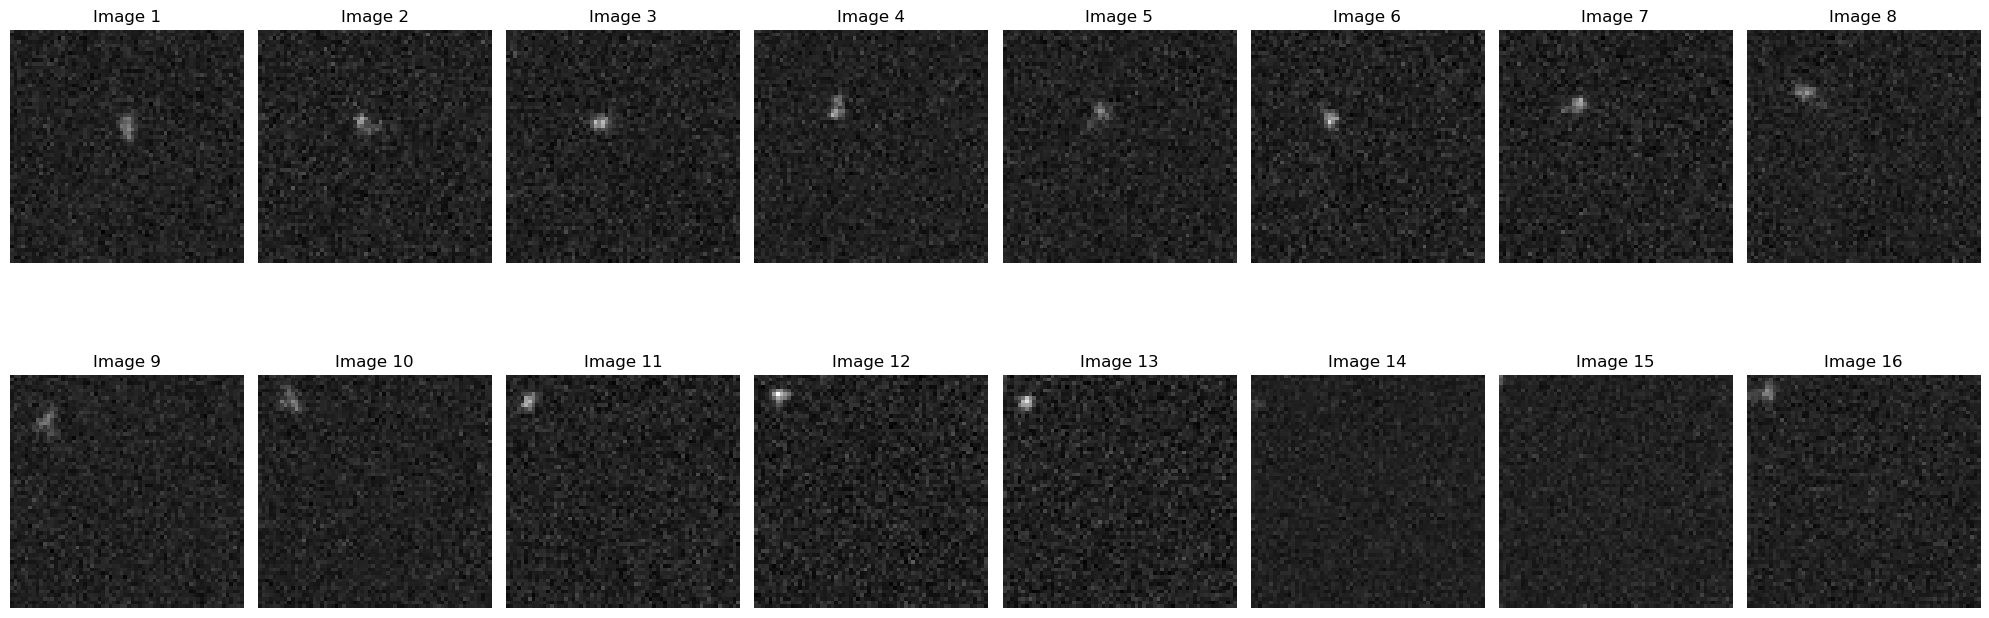

Global Min Intensity: 0.0, Global Max Intensity: 0.7666015625


In [10]:
# Plots self-generated images for comparison
global_min_gen = float("inf")
global_max_gen = float("-inf")

images_arr, estimatedDs =  generateImagesAndEstimateDMAXD(1, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
images = images_arr[0]

global_min_gen = np.min(images)
global_max_gen = np.max(images)

# Display up to 16 images in 2 rows of 8 images each, on the same scale
num_images = min(16, len(images))  # Ensure we don't exceed 16 images
rows, cols = 2, 8  # 2 rows, 8 images per row
plt.figure(figsize=(20, 8))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i], cmap="gray", vmin=global_min_gen, vmax=global_max_gen)
    plt.title(f"Image {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

print(f"Global Min Intensity: {global_min_gen}, Global Max Intensity: {global_max_gen}")